In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [4]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

### Setup directory variables

In [5]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [7]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

## Setup plots

In [8]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 0.8)
cmap = my_get_cmap('pair')

## Load data

In [9]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)

In [10]:
df['sex'].unique()

array([2, 1])

In [11]:
print(np.sum(df.loc[:,'sex'] == 1))
print((np.sum(df.loc[:,'sex'] == 1)/df.shape[0]) * 100)

486
45.50561797752809


In [12]:
print(np.sum(df.loc[:,'sex'] == 2))
print((np.sum(df.loc[:,'sex'] == 2)/df.shape[0]) * 100)

582
54.49438202247191


In [13]:
df['ageAtScan1_Years'].mean()

15.364513108614235

In [14]:
df['ageAtScan1_Years'].std()

3.4238927087439732

### Sex

In [15]:
stats = pd.DataFrame(index = phenos, columns = ['test_stat', 'pval'])

for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex'] == 1,pheno]
    y = df.loc[df.loc[:,'sex'] == 2,pheno]
    
    test_output = sp.stats.ttest_ind(x,y)
    stats.loc[pheno,'test_stat'] = test_output[0]
    stats.loc[pheno,'pval'] = test_output[1]
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

stats

,test_stat,pval,pval_corr,sig
Overall_Psychopathology,-1.78638,0.0743212,0.0743212,False
Psychosis_Positive,2.34033,0.0194505,0.0291757,True
Psychosis_NegativeDisorg,3.40847,0.000677704,0.00203311,True


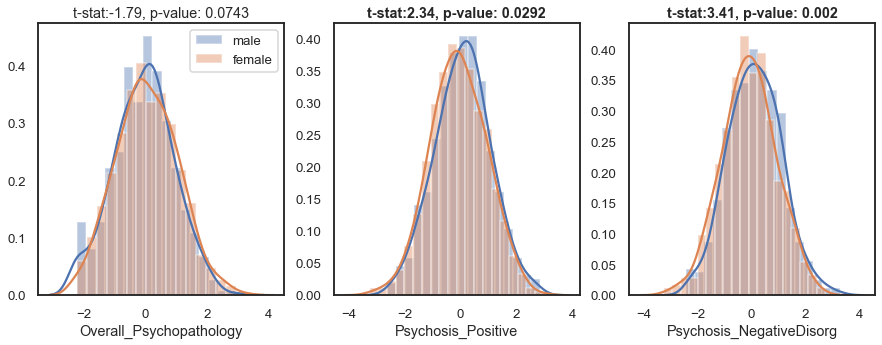

In [16]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

# sex: 1=male, 2=female
for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex'] == 1,pheno]
    sns.distplot(x, ax = ax[i], label = 'male')

    y = df.loc[df.loc[:,'sex'] == 2,pheno]
    sns.distplot(y, ax = ax[i], label = 'female')
    
    if i == 0:
        ax[i].legend()
    ax[i].set_xlabel(pheno)

    if stats.loc[pheno,'sig']:
        ax[i].set_title('t-stat:' + str(np.round(stats.loc[pheno,'test_stat'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)), fontweight="bold")
    else:
        ax[i].set_title('t-stat:' + str(np.round(stats.loc[pheno,'test_stat'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)))
        
f.savefig(outfile_prefix+'symptoms_distributions_sex.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Age

In [17]:
stats = pd.DataFrame(index = phenos, columns = ['r', 'pval'])

x = df['ageAtScan1_Years']
for i, pheno in enumerate(phenos):
    y = df[pheno]
    r,p = sp.stats.pearsonr(x,y)
    
    stats.loc[pheno,'r'] = r
    stats.loc[pheno,'pval'] = p
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

stats

,r,pval,pval_corr,sig
Overall_Psychopathology,0.291851,2.04707e-22,6.1412e-22,True
Psychosis_Positive,-0.0938992,0.00212739,0.00319109,True
Psychosis_NegativeDisorg,-0.0274496,0.370158,0.370158,False


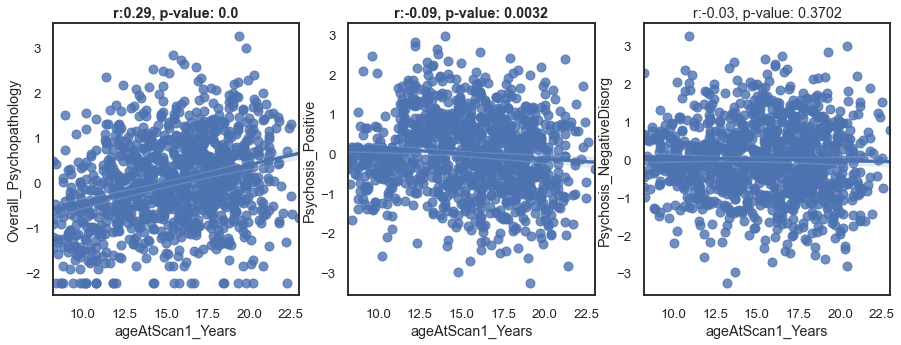

In [18]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

x = df['ageAtScan1_Years']
for i, pheno in enumerate(phenos):
    y = df[pheno]
    sns.regplot(x, y, ax=ax[i])
    
    if stats.loc[pheno,'sig']:
        ax[i].set_title('r:' + str(np.round(stats.loc[pheno,'r'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)), fontweight="bold")
    else:
        ax[i].set_title('r:' + str(np.round(stats.loc[pheno,'r'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)))
    
f.savefig(outfile_prefix+'symptoms_correlations_age.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Diagnostic table

In [19]:
# to_screen = ['goassessSmryPsy', 'goassessSmryMood', 'goassessSmryEat', 'goassessSmryAnx', 'goassessSmryBeh']
# counts = np.sum(df.loc[:,to_screen] == 4)
# print(counts)
# print(counts/df.shape[0]*100)

In [20]:
df['goassessDxpmr4_bin'] = df.loc[:,'goassessDxpmr4'] == '4PS'
df['goassessDxpmr4_bin'] = df['goassessDxpmr4_bin'].astype(int)*4

In [21]:
to_screen = ['goassessDxpmr4_bin','goassessSmryMan', 'goassessSmryDep', 'goassessSmryBul', 'goassessSmryAno', 'goassessSmrySoc',
             'goassessSmryPan', 'goassessSmryAgr', 'goassessSmryOcd', 'goassessSmryPtd', 'goassessSmryAdd',
            'goassessSmryOdd', 'goassessSmryCon']
counts = np.sum(df.loc[:,to_screen] == 4)
print(counts)
print(counts/df.shape[0]*100)

goassessDxpmr4_bin    303
goassessSmryMan        11
goassessSmryDep       156
goassessSmryBul         4
goassessSmryAno        15
goassessSmrySoc       261
goassessSmryPan        10
goassessSmryAgr        61
goassessSmryOcd        30
goassessSmryPtd       136
goassessSmryAdd       168
goassessSmryOdd       353
goassessSmryCon        85
dtype: int64
goassessDxpmr4_bin    28.370787
goassessSmryMan        1.029963
goassessSmryDep       14.606742
goassessSmryBul        0.374532
goassessSmryAno        1.404494
goassessSmrySoc       24.438202
goassessSmryPan        0.936330
goassessSmryAgr        5.711610
goassessSmryOcd        2.808989
goassessSmryPtd       12.734082
goassessSmryAdd       15.730337
goassessSmryOdd       33.052434
goassessSmryCon        7.958801
dtype: float64


In [22]:
to_keep = counts[counts >= 50].index
list(to_keep)

['goassessDxpmr4_bin',
 'goassessSmryDep',
 'goassessSmrySoc',
 'goassessSmryAgr',
 'goassessSmryPtd',
 'goassessSmryAdd',
 'goassessSmryOdd',
 'goassessSmryCon']

In [23]:
counts[counts >= 50]

goassessDxpmr4_bin    303
goassessSmryDep       156
goassessSmrySoc       261
goassessSmryAgr        61
goassessSmryPtd       136
goassessSmryAdd       168
goassessSmryOdd       353
goassessSmryCon        85
dtype: int64

In [24]:
my_xticklabels = ['Psychosis spectrum (n=303)',
                 'Depression (n=156)',
                 'Social anxiety disorder (n=261)',
                 'Agoraphobia (n=61)',
                 'PTSD (n=136)',
                 'ADHD (n=168)',
                 'ODD (n=353)',
                 'Conduct disorder (n=85)']

In [25]:
sns.set(style='white', context = 'paper', font_scale = 1)

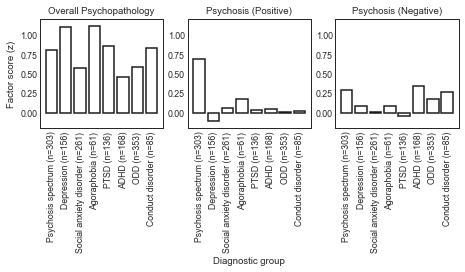

In [26]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*2.5)
f.set_figheight(2)

for i, pheno in enumerate(phenos):
    mean_scores = np.zeros(len(to_keep))
    for j, diagnostic_score in enumerate(to_keep):
        idx = df.loc[:,diagnostic_score] == 4
        mean_scores[j] = df.loc[idx,pheno].mean()
    
    ax[i].bar(x = np.arange(0,len(mean_scores)), height = mean_scores, color = 'w', edgecolor = 'k', linewidth = 1.5)
    ax[i].set_ylim([-.2,1.2])
    ax[i].set_xticks(np.arange(0,len(mean_scores)))
    ax[i].set_xticklabels(my_xticklabels, rotation = 90)
    ax[i].tick_params(pad = -2)
    ax[i].set_title(phenos_label[i])
    if i == 1:
        ax[i].set_xlabel('Diagnostic group')
    if i == 0:
        ax[i].set_ylabel('Factor score (z)')
    
f.savefig(outfile_prefix+'symptom_dimensions_groups.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)